## This script prepares the output from CitySim to convert it into an input for BASOPRA EV-HP
### This script uses basopra_updated as environment

In [38]:
import pandas as pd
import numpy as np
import os
import csv
import re
import matplotlib.pyplot as plt

In [204]:
df = pd.read_csv('C:/Users/alejandr.penabell/Downloads/20250404_citysim/val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050/simulation_TH.out',sep='\t')



## The data
The data is in a *1-h resolution*
Per building there are the following columns

'Cooling(Wh)'

'DHWStockTemperature(celsius)'

'ElectricConsumption(kWh)'

'FuelConsumption(MJ)'

'HeatStockTemperature(celsius)'

'Heating(Wh)'

'MachinePower(W)'

'Qi(Wh)'

'Qs(Wh)'

'SolarPVProduction(Wh)'

'SolarThermalProduction(Wh)'

'Ta(celsius)'

'VdotVent(m³/h)'


In [205]:
df.sum()[:14]

#timeStep                                                             3.837318e+07
26930(Building-902138-CH895237183088):0:Ta(celsius)                   2.106791e+05
26930(Building-902138-CH895237183088):0:Heating(Wh)                   1.228662e+07
26930(Building-902138-CH895237183088):0:Cooling(Wh)                  -1.442343e+07
26930(Building-902138-CH895237183088):0:Qi(Wh)                        3.038556e+07
26930(Building-902138-CH895237183088):0:Qs(Wh)                        1.225080e+07
26930(Building-902138-CH895237183088):0:VdotVent(m³/h)                2.822738e+06
26930(Building-902138-CH895237183088):DHWStockTemperature(celsius)    5.277900e+05
26930(Building-902138-CH895237183088):MachinePower(W)                 1.713556e+07
26930(Building-902138-CH895237183088):FuelConsumption(MJ)             6.425831e+04
26930(Building-902138-CH895237183088):ElectricConsumption(kWh)        4.594985e+03
26930(Building-902138-CH895237183088):SolarPVProduction(Wh)           3.947787e+07
2693

In [206]:
building_outputs = {}

for col in df.columns:
    if ':' not in col or col.startswith('#timeStep'):
        continue
    parts = col.split(':')
    building_id = parts[0]
    output_type = parts[-1]
    building_outputs.setdefault(building_id, set()).add(output_type)

print("Number of buildings:", len(building_outputs))
for building, outputs in building_outputs.items():
    print("Building:", building, "has outputs:", sorted(outputs))

Number of buildings: 6
Building: 26930(Building-902138-CH895237183088) has outputs: ['Cooling(Wh)', 'DHWStockTemperature(celsius)', 'ElectricConsumption(kWh)', 'FuelConsumption(MJ)', 'Heating(Wh)', 'MachinePower(W)', 'Qi(Wh)', 'Qs(Wh)', 'SolarPVProduction(Wh)', 'SolarThermalProduction(Wh)', 'Ta(celsius)', 'VdotVent(m³/h)']
Building: 26931(Building-902142-CH963752308786) has outputs: ['Cooling(Wh)', 'DHWStockTemperature(celsius)', 'ElectricConsumption(kWh)', 'FuelConsumption(MJ)', 'Heating(Wh)', 'MachinePower(W)', 'Qi(Wh)', 'Qs(Wh)', 'SolarPVProduction(Wh)', 'SolarThermalProduction(Wh)', 'Ta(celsius)', 'VdotVent(m³/h)']
Building: 26932(Building-190183183-CH113098523737) has outputs: ['Cooling(Wh)', 'DHWStockTemperature(celsius)', 'ElectricConsumption(kWh)', 'FuelConsumption(MJ)', 'Heating(Wh)', 'MachinePower(W)', 'Qi(Wh)', 'Qs(Wh)', 'SolarPVProduction(Wh)', 'SolarThermalProduction(Wh)', 'Ta(celsius)', 'VdotVent(m³/h)']
Building: 26933(Building-902139-CH503730975261) has outputs: ['Cooli

In [207]:
['Cooling(Wh)', 'DHWStockTemperature(celsius)', 'ElectricConsumption(kWh)', 'FuelConsumption(MJ)', 'HeatStockTemperature(celsius)', 'Heating(Wh)', 'MachinePower(W)', 'Qi(Wh)', 'Qs(Wh)', 'SolarPVProduction(Wh)', 'SolarThermalProduction(Wh)', 'Ta(celsius)', 'VdotVent(m³/h)']

['Cooling(Wh)',
 'DHWStockTemperature(celsius)',
 'ElectricConsumption(kWh)',
 'FuelConsumption(MJ)',
 'HeatStockTemperature(celsius)',
 'Heating(Wh)',
 'MachinePower(W)',
 'Qi(Wh)',
 'Qs(Wh)',
 'SolarPVProduction(Wh)',
 'SolarThermalProduction(Wh)',
 'Ta(celsius)',
 'VdotVent(m³/h)']

## For BASOPRA we are only interested on selected outputs:

'SolarPVProduction', 'ElectricConsumption', 'Qs'

Now in kWh

In [208]:
import pandas as pd
import re

def process_citysim_output(df):
    """
    Process a citysim output DataFrame to extract building outputs and create summary dictionaries and a summary DataFrame.
    
    Parameters:
        df (pd.DataFrame): Citysim output DataFrame with columns like 
            '24280(Building-925174-CH913053520904):0:Ta(celsius)'.
    
    Returns:
        building_names (set): Unique building identifiers.
        building_outputs (dict): Keys are building names; values are dicts with outputs of interest (as pd.Series).
        annual_summary (dict): Keys are building names; values are dicts with annual summed outputs.
        summary_df (pd.DataFrame): DataFrame summarizing the annual outputs per building.
    """
    # Extract unique building names.
    building_names = set()
    pattern_name = re.compile(r'^(\d+\([^)]*\))')
    for col in df.columns:
        if col.startswith('#') or col.startswith('Unnamed'):
            continue
        match = pattern_name.match(col)
        if match:
            building_names.add(match.group(1))
    
    # Helper to extract building, output, and unit from a column name.
    def extract_building_output(col):
        pattern = r'^(?P<building>\d+\([^)]*\))(?::\d+)?\:(?P<output>\w+)\((?P<unit>[^)]+)\)$'
        match = re.match(pattern, col)
        if match:
            return match.group('building'), match.group('output'), match.group('unit')
        return None, None, None

    outputs_of_interest = ['SolarPVProduction', 'ElectricConsumption', 'Qs']
    building_outputs = {}
    for col in df.columns:
        if col.startswith('#timeStep') or col.startswith('Unnamed'):
            continue
        building, output, unit = extract_building_output(col)
        if building and output in outputs_of_interest:
            if building not in building_outputs:
                building_outputs[building] = {}
            # Convert from Wh to kWh for SolarPVProduction and Qs.
            if output in ['SolarPVProduction', 'Qs'] and unit == 'Wh':
                building_outputs[building][output] = df[col] / 1000.0
            else:
                building_outputs[building][output] = df[col]
    
    # Create annual summary (summing each output).
    annual_summary = {}
    for building in building_names:
        annual_summary[building] = {}
        for output in outputs_of_interest:
            if building in building_outputs and output in building_outputs[building]:
                annual_summary[building][output] = building_outputs[building][output].sum()
            else:
                annual_summary[building][output] = None
                
    summary_df = pd.DataFrame.from_dict(annual_summary, orient='index')
    
    return building_names, building_outputs, annual_summary, summary_df

# Example usage:
# building_names, building_outputs, annual_summary, summary_df = process_citysim_output(df)
# print("Buildings:", sorted(building_names))
# print("Annual outputs per building:")
# print(summary_df)


There are several buildings per output

In [209]:
[building_names, building_outputs, annual_summary, summary_df] = process_citysim_output(df)


In [210]:
import pickle
def save_obj(obj, name):
    with open('../Input/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


In [211]:
save_obj(building_outputs,'val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050')

In [49]:
len(building_names)

5

In [50]:
building_names

{'26930(Building-902138-CH895237183088)',
 '26931(Building-902142-CH963752308786)',
 '26932(Building-190183183-CH113098523737)',
 '26933(Building-902139-CH503730975261)',
 '26934(Building-902141-CH513082523745)'}

In [56]:
building

'24278(Building-925098-CH943052901142)'

<Axes: >

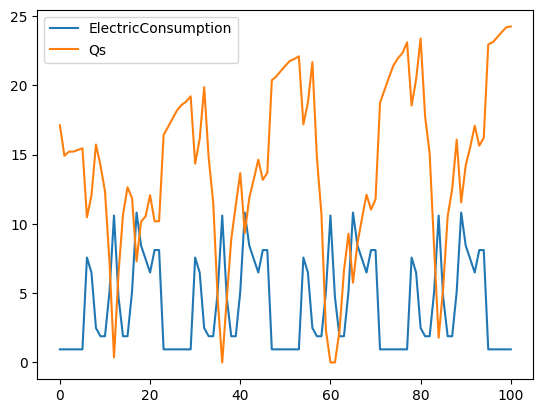

In [57]:
pd.DataFrame(building_outputs['24288(Building-9014588-CH729613523003)']).loc[:100,['ElectricConsumption','Qs']].plot()


<Axes: >

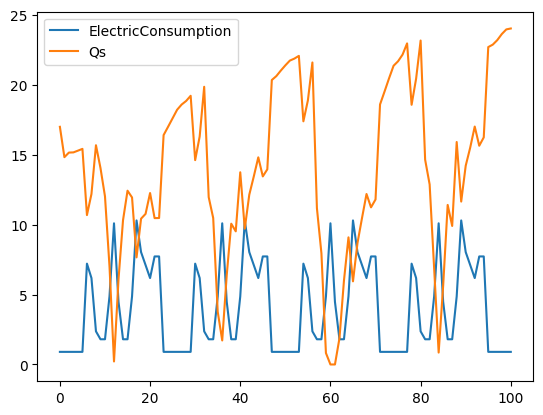

In [58]:
pd.DataFrame(building_outputs['24283(Building-925146-CH109630105229)']).loc[:100,['ElectricConsumption','Qs']].plot()

In [45]:
pd.DataFrame(building_outputs['24288(Building-9014588-CH729613523003)']).to_csv('example_building_city_sim.csv')

For the moment we have only an input from the PV, not yet included in CitySim output

In [50]:
df_pv = pd.read_csv('../Input/baseline_DeepBlue_TH.tsv',sep='\t')

In [51]:
df_pv.head()

,#timeStep,1(972666):0:Ta(celsius),1(972666):0:Heating(Wh),1(972666):0:Cooling(Wh),1(972666):0:Qi(Wh),1(972666):0:Qs(Wh),1(972666):0:VdotVent(m³/h),1(972666):HeatStockTemperature(celsius),1(972666):MachinePower(W),1(972666):FuelConsumption(MJ),...,3(972640):0:Qi(Wh),3(972640):0:Qs(Wh),3(972640):0:VdotVent(m³/h),3(972640):HeatStockTemperature(celsius),3(972640):MachinePower(W),3(972640):FuelConsumption(MJ),3(972640):ElectricConsumption(kWh),3(972640):SolarPVProduction(Wh),3(972640):SolarThermalProduction(Wh),Unnamed: 37
0,1,20.0,16343,0,1323,16343,0.0,60.0,24743,92.788,...,1213,15222,0.0,60.0,23622,88.584,0.248,0,0,NaN
1,2,20.0,16261,0,1323,16261,0.0,60.0,24661,92.477,...,1213,15030,0.0,60.0,23430,87.862,0.248,0,0,NaN
2,3,20.0,16562,0,1323,16562,0.0,60.0,24962,93.607,...,1213,15309,0.0,60.0,23709,88.909,0.248,0,0,NaN
3,4,20.0,16768,0,1323,16768,0.0,60.0,25168,94.380,...,1213,15495,0.0,60.0,23895,89.607,0.248,0,0,NaN
4,5,20.0,16969,0,1323,16969,0.0,60.0,25369,95.135,...,1213,15682,0.0,60.0,24082,90.308,0.248,0,0,NaN


In [59]:
[building_names, building_outputs, annual_summary, summary_df] = process_citysim_output(df_pv)


In [60]:
building_names

{'1(972666)', '2(504125937)', '3(972640)'}

In [61]:
building_outputs

{'1(972666)': {'Qs': 0       16.343
  1       16.261
  2       16.562
  3       16.768
  4       16.969
           ...  
  8755    23.206
  8756    23.650
  8757    23.339
  8758    23.543
  8759    25.554
  Name: 1(972666):0:Qs(Wh), Length: 8760, dtype: float64,
  'ElectricConsumption': 0       0.270
  1       0.270
  2       0.270
  3       0.270
  4       0.270
          ...  
  8755    2.133
  8756    1.855
  8757    2.318
  8758    2.318
  8759    0.270
  Name: 1(972666):ElectricConsumption(kWh), Length: 8760, dtype: float64,
  'SolarPVProduction': 0       0.0
  1       0.0
  2       0.0
  3       0.0
  4       0.0
         ... 
  8755    0.0
  8756    0.0
  8757    0.0
  8758    0.0
  8759    0.0
  Name: 1(972666):SolarPVProduction(Wh), Length: 8760, dtype: float64},
 '2(504125937)': {'Qs': 0        8.608
  1        8.464
  2        8.547
  3        8.600
  4        8.655
           ...  
  8755    11.391
  8756    11.476
  8757    11.457
  8758    11.545
  8759    11.630
  Name:

In [62]:
summary_df

,SolarPVProduction,ElectricConsumption,Qs
1(972666),18098.170,11025.190,85331.433
3(972640),9112.617,10107.945,79952.963
2(504125937),0.000,4502.275,39771.509


In [64]:
pd.DataFrame(building_outputs['1(972666)']).to_csv('example_Jerome.csv')